<a href="https://colab.research.google.com/github/rgmantovani/advancedML/blob/master/codes/aula_02b_mlp/MLP_exemplo1_simples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptron Multicamadas (*Multilayer Perceptron - MLP*)

Disciplina: Métodos e Modelos Avançados em Ciência de Dados

Especialização em Ciência de Dados - Universidade Tecnologica Federal do Paraná

Aula 01B: Perceptron Multicamadas (MLP)

Exemplo 01: Executando MLP em datasets simples

Prof. Dr. Rafael Gomes mantovani

---

In [ ]:
# Adicionando um seed para reproducibilidade do exemplo 
set.seed(42)

Para termos uma MLP própria, iremos codificar algumas funções:

* **mlp.create**: instancia uma MLP recebendo alguns parâmetros para determinar sua arquitetura (topologia); 
* **mlp.forward**: propaga o sinal (exemplo) recebido, ativando os neurônios da camada de entrada até a camada de saída;
* **mlp.train**: treina a MLP em um conjunto de treinamento, passado como parâmetro para a rede
* **mlp.test**: faz a predição para os valores contidos em um novo conjunto de teste

Também iremos precisar de mais duas funções:
* **fnet**: uma função de ativação, contínua e derivável
* **dfnet**: a função derivada da função de ativação, que irá ser usada para computar os gradientes de ajuste dos pesos sinápticos entre as camadas da MLP

In [12]:
# -----------------------------------------------------------------
# Função de ativaçao e sua função derivada
#   - v é o sinal recebido pelo neurônio/unidade
# -----------------------------------------------------------------

# função de ativaçao sigmoidal
fnet = function(v){
  return (1 / (1+exp(-v)))
}

# função derivada de fnet (fnet já está computado para o sinal v)
# quando chamamos ela dentro do treinamento da MLP, fnet é um vetor
dfnet = function(f_net){
  return (f_net * (1 - f_net))
} 


In [13]:
# -----------------------------------------------------------------
# Inicialização do modelo (MLP)
#   - input.length: tamanho da camada de entrada
#   - hidden.length: quantidade de neurônios da camada oculta
#   - output.length: quantidad de
# -----------------------------------------------------------------

mlp.create = function(input.length = 2, hidden.length = 2,
  output.length = 1) {

  # cria um objeto (modelo) para retornarmos no fim da função
  model = list()
  
  # instanciar a topologia da rede
  model$input.length  = input.length
  model$hidden.length = hidden.length
  model$output.length = output.length

  # salvamos também as funcoes no modelo
  model$fnet  = fnet
  model$dfnet = dfnet
  
  # criamos pesos 'ocultos' nas nossas unidades (bias)
  # e geramos os pesos aleatoriamente com valores entre [-0.5, 0.5]
  # isso vai ser salvo em uma matriz (hidden), sao os pesos sinápticos
  # entre a camada de entrada e a camada oculta
  # 		X1	     X2    Bias
  # 1   w11     w12    w13
  # 2 	w21     w22    w23
  wh = runif(min = -0.5, max = 0.5, n = hidden.length * (input.length + 1))
  model$hidden = matrix(data = wh, nrow = hidden.length, ncol = input.length + 1)

  # repetimos o processo anterior mas agora criando pesos sinápticos entre
  # a camada coluta e a camada de saida
  wo = runif(min = -0.5, max = 0.5, n = output.length * (hidden.length + 1))
  model$output = matrix(data = wo, nrow = output.length, ncol = hidden.length + 1)

  # retornamos nosso objeto (modelo), com toda essa informação gerada
  return(model)
}


In [2]:
# -----------------------------------------------------------------
# propaga o sinal pela MLP da camada de entrada até a saída (forward)
#   - model:   modelo criado pela função mlp.create
#   - example: um exemplo/instância/linha do dataset de treinamento
# -----------------------------------------------------------------

mlp.forward = function(model, example) {

  # propaga o sinal da entrada para a camada oculta
  # adicionamos um sinal positivo para o bias (+1)
  net.hidden  = model$hidden %*% as.numeric(c(example, 1))
  fnet.hidden = model$fnet(net.hidden)

  # propaga o sinal da camada oculta para a saída
  # adicionamos um sinal positivo para o bias (+1)
  net.output = model$output %*% c(as.numeric(fnet.hidden),1)
  fnet.output = model$fnet(net.output)

  # retornando os valores computados em cada camada
  res = list(net.hidden = net.hidden, fnet.hidden = fnet.hidden,
    net.output = net.output, fnet.output = fnet.output)

  return(res)
}


In [3]:
# -----------------------------------------------------------------
# Função para treinamento da MLP
#   - model:   modelo que instanciamos com mlp.create
#   - dataset: conjunto de treinamento
#   - lrn.rate: taxa de aprendizado
#   - threshold: taxa de erro aceitável para interromper o treinamento
#   - n.iter: número máximo de épocas para permitir o treinamento
# -----------------------------------------------------------------

mlp.train = function(model, dataset, lrn.rate = 0.1, threshold = 1e-3, 
   n.iter = 1000) {
  
  squaredError = 2 * threshold
  epochs = 0
  errorVec = c()
  
  # controla o numero de épocas, considerando também o erro 
  # quadrático da iteração
  while(squaredError > threshold & epochs < n.iter) {

    squaredError = 0
    
    # avaliamos todas as instâncias do dataset (época)
    for(p in 1:nrow(dataset)) {
      
      # acesar o exemplo corrente e seu rótulo (target/label)
      Xp = as.numeric(dataset[p,1:model$input.length])
      Yp = as.numeric(dataset[p,(model$input.length+1):ncol(dataset)])
      
      # movemos o sinal pela rede, usando mlp.forward
      res = mlp.forward(model = model, example = Xp)
      
      # obtemos a saída obtida (predita)
      Op  = res$fnet.output
      
      # obtemos a medida de erro do classificador
      error = (Yp - Op)
      
      # calculamos o erro quadrático para esse exemplo
      squaredError = squaredError + sum(error^2)
      
      # computamos delta.output (delta_o) - variaçao dos pesos na camada de saída
      # delta_o = (Yp - Op) * f'(net_output)
      delta.output = error * model$dfnet(Op)
    
      # computamos delta.hidden (delta_h) - variação dos pesos na camada oculta
      # delta_h = f'(net_hidden) * sum(delta_o * Wo)
      Wo = model$output[, 1:model$hidden.length]
      delta.hidden = as.numeric(model$dfnet(res$fnet.hidden)) * (as.numeric(delta.output) %*% Wo)
      
      # computamos os novos pesos sinápticos do modelo (Wo and Wh)
      new.W.output = model$output + lrn.rate * (delta.output %*% as.vector(c(res$fnet.hidden,1)))
      new.W.hidden = model$hidden + lrn.rate * (t(delta.hidden) %*% as.vector(c(Xp,1)))
      
      # atualizamos os pesos sinápticos da rede
      model$hidden = new.W.hidden
      model$output = new.W.output
    }
    
    # calculando o erro quadrático da época
    squaredError = squaredError / nrow(dataset)
    errorVec = c(errorVec, squaredError)
    epochs = epochs + 1
    cat("Época: ", epochs, "- Error: ", squaredError, "\n")
  }
  
  # returning o modelo treinado depois das épocas
  ret = list(model = model, epochs = epochs, errorVec = errorVec)
  return(ret)
}


In [21]:
# -----------------------------------------------------------------
# Função para realizar predições em exemplos de teste
#   - model:   model já treinado (depois de executar mlp.train)
#   - example: exemplo para ser predito
# -----------------------------------------------------------------
mlp.test = function(model, example) {
  res = mlp.forward(model = model, example = example)
  return(res)
}

In [4]:
# para gerar algumas análies gráficas vamos carregar o pacote ggplot2
library("ggplot2")

In [5]:
# -----------------------------------------------------------------
# Carregando dataset - temos diferentes exemplos para tentar
# -----------------------------------------------------------------

#creates XOR dataset
x1    = c(0,0,1,1)
x2    = c(0,1,0,1)
class = c(0,1,1,0)

dataset = data.frame(x1, x2, class)

In [6]:
dataset

x1,x2,class
<dbl>,<dbl>,<dbl>
0,0,0
0,1,1
1,0,1
1,1,0


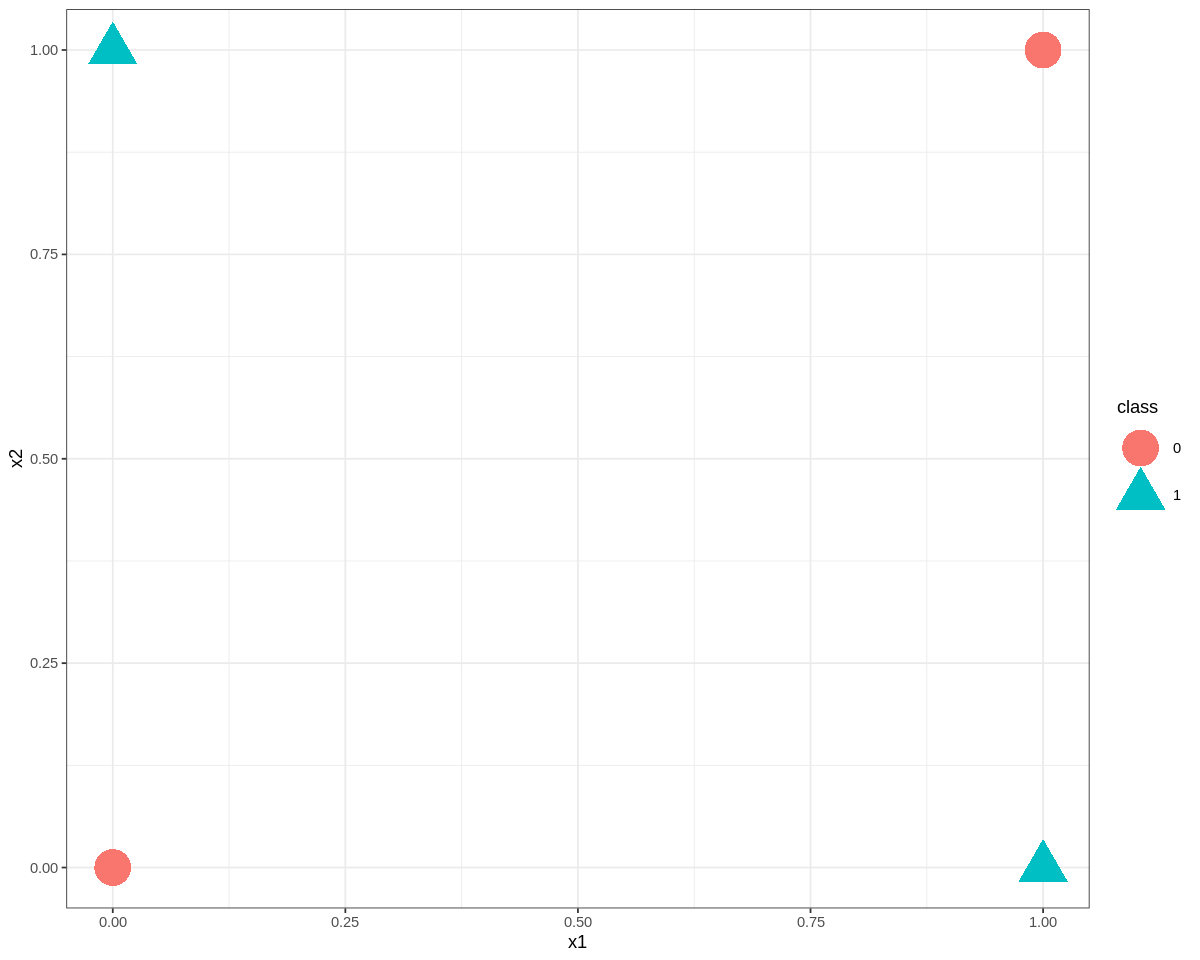

In [10]:
# plotar para visualizar o problema em 2 dimensões
dataPlot = dataset
dataPlot$class = as.factor(dataPlot$class)
g2 = ggplot(dataPlot, mapping = aes(x = x1, y = x2, colour = class, shape = class))
g2 = g2 + geom_point(size = 10) + theme_bw()

options(repr.plot.width=10, repr.plot.height=8)
print(g2)

In [14]:
# -----------------------------------------------------------------
# Instanciando MLP
# -----------------------------------------------------------------

model = mlp.create(input.length = 2, hidden.length = 2, output.length = 1)

print(model)

$input.length
[1] 2

$hidden.length
[1] 2

$output.length
[1] 1

$fnet
function(v){
  return (1 / (1+exp(-v)))
}

$dfnet
function(f_net){
  return (f_net * (1 - f_net))
}

$hidden
           [,1]       [,2]       [,3]
[1,] -0.4666102 -0.1066352 -0.1522788
[2,]  0.0282212 -0.4560043  0.3618966

$output
           [,1]       [,2]       [,3]
[1,] -0.2112685 -0.4176574 0.02743781



In [16]:
# -----------------------------------------------------------------
# Treinando a MLP
# -----------------------------------------------------------------

# conjunto de treinamento = dataset
# taxa de aprendizado     = 0.1
# threshold de erro       = 0.01
# iteracoes maximas       = 1000


# defines the stopping criteria with and error < 0.001 and epochs < 100k
obj = mlp.train(model = model, dataset = dataset, lrn.rate = 0.1,
  threshold = 1e-2, n.iter = 10000)

Época:  1 - Error:  0.2569401 
Época:  2 - Error:  0.2566237 
Época:  3 - Error:  0.2563282 
Época:  4 - Error:  0.2560523 
Época:  5 - Error:  0.2557947 
Época:  6 - Error:  0.2555543 
Época:  7 - Error:  0.25533 
Época:  8 - Error:  0.2551208 
Época:  9 - Error:  0.2549256 
Época:  10 - Error:  0.2547436 
Época:  11 - Error:  0.254574 
Época:  12 - Error:  0.2544158 
Época:  13 - Error:  0.2542684 
Época:  14 - Error:  0.2541311 
Época:  15 - Error:  0.2540031 
Época:  16 - Error:  0.2538839 
Época:  17 - Error:  0.2537728 
Época:  18 - Error:  0.2536693 
Época:  19 - Error:  0.253573 
Época:  20 - Error:  0.2534832 
Época:  21 - Error:  0.2533997 
Época:  22 - Error:  0.2533218 
Época:  23 - Error:  0.2532494 
Época:  24 - Error:  0.2531819 
Época:  25 - Error:  0.2531191 
Época:  26 - Error:  0.2530607 
Época:  27 - Error:  0.2530063 
Época:  28 - Error:  0.2529556 
Época:  29 - Error:  0.2529085 
Época:  30 - Error:  0.2528646 
Época:  31 - Error:  0.2528237 
Época:  32 - Error:  

In [17]:
# -----------------------------------------------------------------
# criar dataframe com o historico do treinamento 
# (epoca - erro da epoca)
# -----------------------------------------------------------------

df = data.frame(1:length(obj$errorVec), obj$errorVec)
colnames(df) = c("epochs", "error")
head(df)

,epochs,error
,<int>,<dbl>
1,1,0.2569401
2,2,0.2566237
3,3,0.2563282
4,4,0.2560523
5,5,0.2557947
6,6,0.2555543


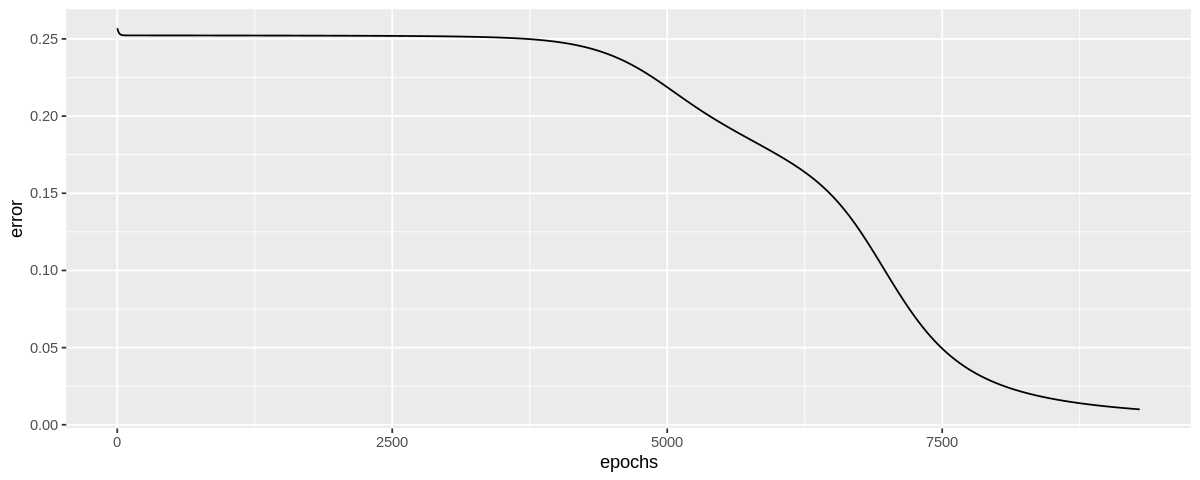

In [19]:
# -----------------------------------------------------------------
# Plotar a curva de convergência do erro de treinamento
# -----------------------------------------------------------------

g = ggplot(df, aes(x = epochs, y = error))
g = g + geom_line() 
g = g + scale_x_continuous(limit = c(1, nrow(df)))

options(repr.plot.width=10, repr.plot.height=4)
print(g)


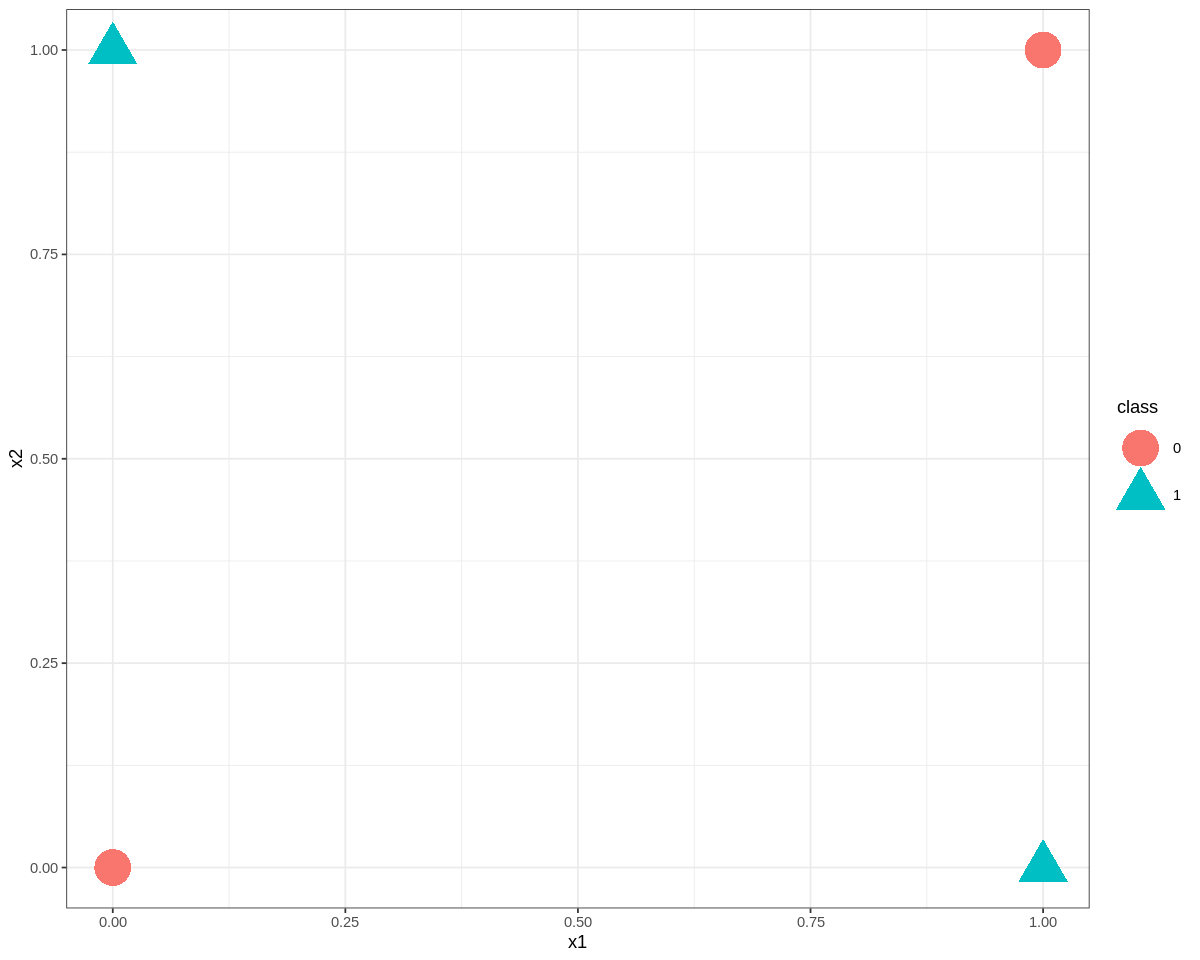

In [23]:
# -----------------------------------------------------------------
# Plotando predição
# -----------------------------------------------------------------

dataPlot = dataset
dataPlot$class = as.factor(dataPlot$class)
g2 = ggplot(dataPlot, mapping = aes(x = x1, y = x2, colour = class, shape = class))
g2 = g2 + geom_point(size = 10) + theme_bw()

# visualizando ...
options(repr.plot.width=10, repr.plot.height=8)
print(g2)

In [34]:
# Predizendo classe para valores de teste

test.example = c(0,0)
pred2 = mlp.test(model = obj$model, example = test.example)
pred.class = round(pred2$fnet.output)
print(pred.class)


     [,1]
[1,]    0


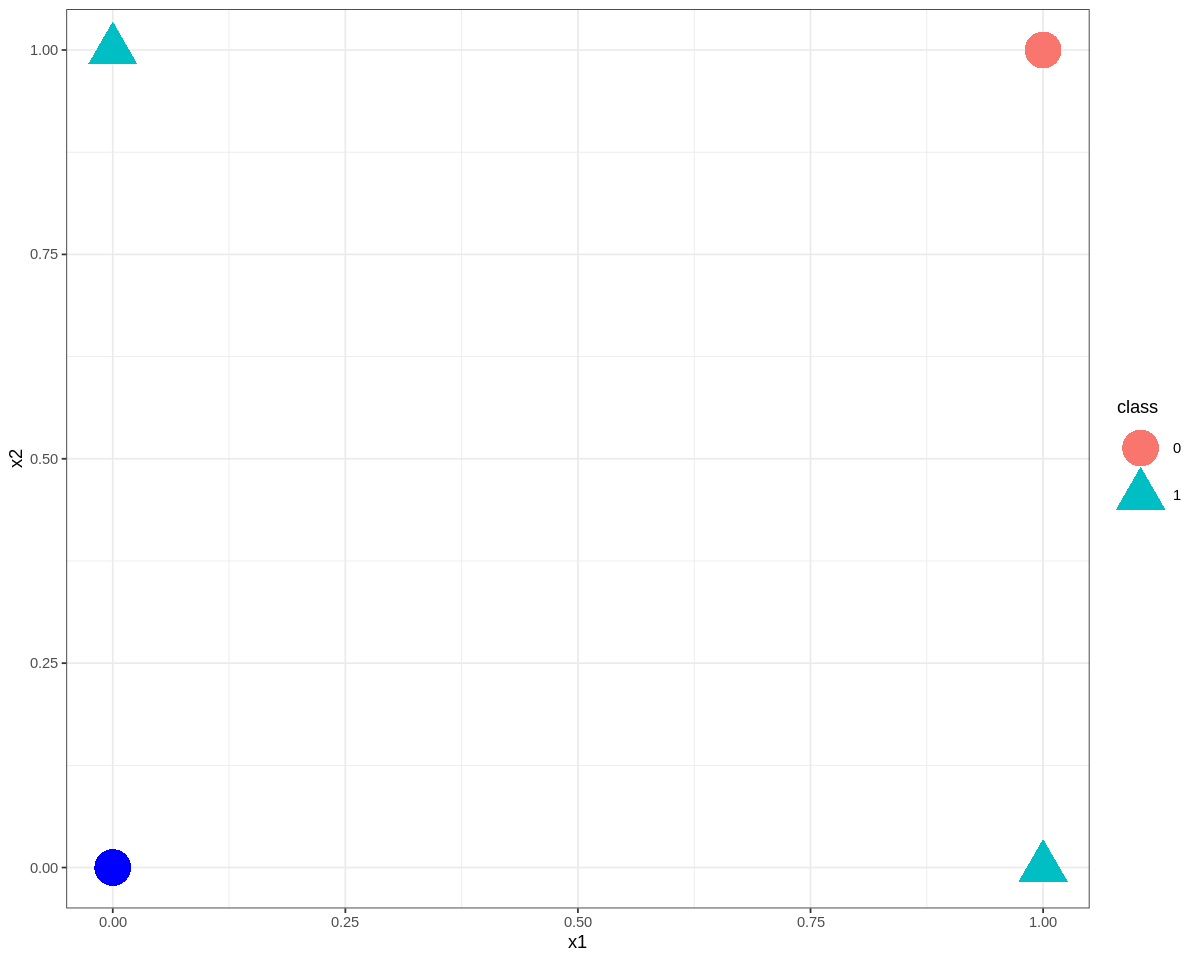

In [36]:
# -----------------------------------------------------------------
# vendo nossas predições 
# -----------------------------------------------------------------

g3 = g2 + annotate("point", x = test.example[1], y = test.example[2], 
  colour = "blue", size = 10, shape = 16)
print(g3)
